# CNN - AE model validation

In [1]:
import os
import csv
import random
import umap
import numpy as np
from os import path
from scipy import stats
from sklearn import preprocessing
from sklearn.manifold.t_sne import TSNE
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
%matplotlib inline

### Load data

In [33]:
# data directories
homedir = os.path.expanduser('~')
prjdir = 'data1/stratification_ILRM'
datadir = 'data'
outdir = path.join(homedir, prjdir, datadir, 'neurodev-disorder')
expdir = path.join(homedir, prjdir, datadir, 'experiments/neurodev-disorder-2019-03-14-05-15-16-nobn-noact-norelu-10-l64')
# sub-sampling
n_samples = None

# get the list of diagnosed diseases associated with mrns
with open(path.join(outdir, 'cohort-mrn_diseases.csv')) as f:
    rd = csv.reader(f)
    mrn_disease = {r[0]: r[1::] for r in rd}

# evaluate potential disease classes

# read encoded vectors file and ordered medical record numbers
with open(path.join(expdir, 'mrns.csv')) as f:
    rd = csv.reader(f)
    mrns = [r[0] for r in rd]
    
# (1) first diagnosis
gt_disease = {}
for m in mrn_disease:
    if mrn_disease[m][0]!='pervasive developmental disorder' and m in mrns:
        gt_disease[m] = mrn_disease[m][0]
    else:
        pass

with open(path.join(expdir, 'encoded_vect.csv')) as f:
    rd = csv.reader(f)
    encoded = [list(map(float, r)) for r in rd]

tmp_mrns = []
tmp_encoded = []
for idx, m in enumerate(mrns):
    if m in gt_disease.keys():
        tmp_mrns.append(m)
        tmp_encoded.append(encoded[idx])
    else:
        pass
mrns = tmp_mrns
encoded = tmp_encoded

In [34]:
len(gt_disease)

13031

In [35]:
set_mrns = set(mrns)
    
# read the vocabulary
with open(path.join(outdir, 'cohort-new_vocab.csv')) as f:    
    rd = csv.reader(f)
    next(rd)
    vocab = {r[1]: r[0] for r in rd}
len_vocab = len(vocab)

# read raw data
with open(path.join(outdir, 'cohort-new_ehr.csv')) as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        if r[0] in gt_disease.keys():
            raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))

# raw data (scaled) counts
scaler = StandardScaler()
data = raw_ehr.values()
mrn_list = list(raw_ehr.keys())
raw_data = np.zeros((len(data), len_vocab))
for idx, token_list in enumerate(data):
    for t in token_list:
        raw_data[idx, t - 1] += 1

raw_data_scaled = scaler.fit_transform(raw_data)

# ##Read LSTM encoded vectors file and ordered medical record numbers
# with open(expdir + '/LSTMencoded_vect.csv') as f:
#     rd = csv.reader(f)
#     lstm_encoded_vect = []
#     for r in rd:
#         lstm_encoded_vect.append(list(map(float, r))) 
#     #svd = TruncatedSVD(lstm_encoded_vect, n_components=100)
#     #lstm_encoded_vect = svd.fit_transform(lstm_encoded_vect)
    
# with open(expdir + '/LSTMmrns.csv') as f:
#     rd = csv.reader(f)
#     lstm_mrns = []
#     for r in rd:
#         lstm_mrns.append(r[0])

In [36]:
# tmp_mrns = []
# tmp_encoded = []
# for idx, m in enumerate(lstm_mrns):
#     if m in gt_disease.keys():
#         tmp_mrns.append(m)
#         tmp_encoded.append(lstm_encoded_vect[idx])
#     else:
#         pass
# lstm_mrns = tmp_mrns
# lstm_encoded_vect = tmp_encoded

In [37]:
disease_count = {}
for d in gt_disease.values():
    if d not in disease_count:
        disease_count[d] = 1
    else:
        disease_count[d] += 1
print(len(gt_disease))

13031


In [38]:
disease_count

{'OTH': 4894,
 'attention deficit': 5924,
 'autism': 814,
 'mental retardation': 1399}

>`svd_tfidf():` returns the SVD matrix of the TFIDF matrix of the raw ehr data;

>`silhouette_analysis():` hierarchical clustering on input data maximizing the Silhouette Index

>`single_plot():` one plot of all the clusters

>`nonoveralp_plot():` N different plots, one per cluster, with N = no. of clusters

> `outer_clustering_analysis():` external validation of clustering (entropy and Purity scores)

In [39]:
# Hierarchical clustering parameters
# Frequency count analysis parameters
ehr_strat_model = False

if ehr_strat_model == True:
    HCpar = {'linkage_clu':'complete',
             'affinity_clu':'cosine',
             'min_cl':2,
             'max_cl':11}
else:
    HCpar = {'linkage_clu':'ward',
             'affinity_clu':'euclidean',
             'min_cl':2,
             'max_cl':11}
FRpar = {'n_terms':20,
        'ty_terms':['icd9', 'medication', 'lab', 'cpt', 'procedure']}

In [40]:
# analyze clustering using silhouette scores
def silhouette_analysis(data,
                        min_clu=HCpar['min_cl'],
                        max_clu=HCpar['max_cl'],
                       preproc=False):
    if preproc:
        data = preprocessing.scale(data)
    # bound analysis range
    if min_clu < 2:
        min_clu = 2

    # run analysis for every clustering size
    best_silh = 0
    silh_scores = []
    for n in range(min_clu, max_clu, 1):
        hclu = AgglomerativeClustering(n_clusters=n,
                                       linkage=HCpar['linkage_clu'],
                                       affinity=HCpar['affinity_clu'])
        lbl = hclu.fit_predict(data).tolist()
        silh = silhouette_score(data, lbl, metric=HCpar['affinity_clu'])
        if silh < 0:
            break
        print(' -- {0}: {1:.3f}'.format(n, silh))
        silh_scores.append(silh)
        if silh > best_silh:
            best_silh = silh
            n_clu = n
            label = lbl
    try:
        print('No. of clusters: {0} -- Silhouette Score: {1:.3f}\n'.format(
            n_clu, best_silh))

    except UnboundLocalError:
        hclu = AgglomerativeClustering(n_clusters=min_clu,
                                       linkage=HCpar['linkage_clu'],
                                       affinity=HCpar['affinity_clu'])
        n_clu = min_clu
        label = hclu.fit_predict(data).tolist()
        print('No. of Clusters: {0} -- Silhouette Score: {1:.3f}\n'.format(
            n_clu, best_silh))

    plt.plot(range(min_clu, max_clu, 1), silh_scores)
    return (n_clu, label, silh_scores)


# SVD matrix of the TFIDF matrix of the raw ehr data
def svd_tfidf(data, len_vocab, n_dimensions=200, tfidf=False):
    if tfidf:
    # apply tf-idf
        tfidf = TfidfTransformer()
        mtx = tfidf.fit_transform(data)
    else:
        scaler = MinMaxScaler()
        mtx = scaler.fit_transform(data)
    # reduce size of the matrix
    svd = TruncatedSVD(n_components=n_dimensions)
    svd_mtx = svd.fit_transform(mtx)

    return svd_mtx


# one plot with all the clusters
def single_plot(data, mrn_disease, colors):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x,y,c=cols, label=cl)
    plt.legend(loc=1)
#     plt.savefig(path.join(homedir, prjdir, datadir, 'neurodev-disorder/neurodev-data.png'))
 
    
# non-overlapping plots, one per cluster
def nonoverlap_plot(data, mrn_disease, colors):
    fig, ax = plt.subplots(len(set(mrn_disease)), 1, figsize=(20, 10*len(set(mrn_disease))))
    for idx, cl in enumerate(set(mrn_disease)):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].scatter(x, y, c=cols, label=cl)
        ax[idx].legend()

        
# external clustering analysis
def outer_clustering_analysis(data, gt_clu, preproc=False):
    
    if preproc:
        data = preprocessing.scale(data)
        
    label_clu = sorted(set(gt_clu))

    # format clustering ground truth
    didx = {d: i for i, d in enumerate(label_clu)}
    idxd = {i:d for d, i in didx.items()}
    gt = [didx[d] for d in gt_clu]

    # validate cluster number
    if len(label_clu) == 1:
        n_clu = 3
    else:
        n_clu = len(label_clu)

    # run clustering
    hclust = AgglomerativeClustering(n_clusters=n_clu,
                                     linkage=HCpar['linkage_clu'],
                                     affinity=HCpar['affinity_clu'])
    clusters = hclust.fit_predict(data).tolist()

    # count cluster occurrences
    cnt_clu = [0] * n_clu
    for c in clusters:
        cnt_clu[c] += 1
    class_clu = [[0] * n_clu for _ in range(len(label_clu))]
    for i, gi in enumerate(gt):
        class_clu[gi][clusters[i]] += 1

    # compute entropy and purity
    entropy = 0
    purity = 0
    for j in range(0, max(clusters) + 1):
        en = 0
        pu = []
        for i in range(0, max(gt) + 1):
            pij = class_clu[i][j] / cnt_clu[j]
            pu.append(pij)
            if pij != 0:
                en += -(pij * np.log2(pij))
        max_pu = max(pu)
        ds_max = []
        for idx, p in enumerate(pu):
            if p == max_pu:
                ds_max.append(idxd[idx])
        print(
            'Cluster: {0} -- '
            'Entropy: {1:.3f}, '
            'Purity: {2:.3f}'.format(j, en, max_pu))
        for d in ds_max:
            print("max(P) in cluster disease {0}".format(d))
        cweight = cnt_clu[j] / len(gt)
        entropy += cweight * en
        purity += cweight * max_pu

    print('Average Entropy: {0:.2f}'.format(entropy))
    print('Average Purity: {0:.2f}'.format(purity))
    
    return clusters

#Input: ehr lists corresponding to a cluster 
#Output: dictionary of term counts
def FreqDict(tokens):
    freq_dict = {}
    tok = []
    for seq in tokens:
        tok.extend(seq)
    
    tok = set(tok)
    for t in tok:
        for seq in tokens:
            if t in seq:
                if t not in freq_dict:
                    freq_dict[t] = 1
                else:
                    freq_dict[t] += 1
    return freq_dict
#Input: dictionary cluster:ehrs; list mrns
#Output:
def freq_term(data, pred_class):
    list_terms = []
    for subc in range(len(set(pred_class))):
        tmp_data = {}
        for j in range(len(pred_class)):
            if pred_class[j] == subc:
                tmp_data.setdefault(subc, list()).append([rd for rd in data[j] 
                                                           if rd!=0 and 
                                                           (str.split(vocab[str(rd)], "::")[0] 
                                                           in FRpar['ty_terms'])])
        print("Cluster {0} numerosity: {1}".format(subc, len(tmp_data[subc])))
        term_count = FreqDict(tmp_data[subc])
        clust_mostfreq = []
        for l in range(FRpar['n_terms']):
            try:
                MFMT = max(term_count, key=(lambda key: term_count[key]))
                num_MFMT = 0
                subc_termc = 0
                for ehr in tmp_data[subc]:
                    for e in ehr:
                        if e == MFMT:
                            subc_termc += 1
                for seq in raw_ehr.values():
                    for t in seq:
                        if t == MFMT:
                            num_MFMT += 1
                print("% most frequent term:{0} "
                       "= {1:.2f} ({2} out of {3} terms in the whole dataset"
                       "-- N patients in cluster {4})".format(vocab[str(MFMT)], 
                                                              subc_termc/num_MFMT, 
                                                              subc_termc,
                                                              num_MFMT,
                                                              term_count[MFMT]))
                term_count.pop(MFMT)
                clust_mostfreq.append(MFMT)
            except ValueError:
                pass
        print("\n")
        list_terms.append(clust_mostfreq)
    return list_terms

##Hierarchical clustering function. Max silhouette.
def hclust_ehr(data):
    best_silh = -1
    list_silh = []
    for nc in range(HCpar['min_cl'],HCpar['max_cl'],1):
        hclust = AgglomerativeClustering(n_clusters=nc, 
                                         linkage=HCpar['linkage_clu'], 
                                         affinity=HCpar['affinity_clu'])
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label, metric=HCpar['affinity_clu'])
        print(nc, tmp_silh)
        list_silh.append(float(tmp_silh))
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = nc
            label = tmp_label
    try:
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    except UnboundLocalError:
        hclust = AgglomerativeClustering(n_clusters=HCpar['min_cl'],
                                         linkage=HCpar['linkage_clu'],
                                         affinity=HCpar['affinity_clu'])
        n_clust = HCpar['min_cl']
        label = hclust.fit_predict(data).tolist()
        best_silh = silhouette_score(data, label)
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    return n_clust, label, list_silh

def chi_test(data, new_classes, term, mrns):
    count_mat = np.zeros((2, len(set(new_classes))), dtype=int)
    for c in set(new_classes):
        for idx, m in enumerate(mrns):
            if new_classes[idx] == c:
                if term in data[idx]:
                    count_mat[1][c] += 1
                else:
                    count_mat[0][c] += 1
    print("Count matrix:\n {0}".format(count_mat))
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(count_mat)
    string = "Chi-squared test statistics: chi2_stat = {0} -- p_val = {1} -- dof = {2}".format(
                                                                  chi2_stat,
                                                                  p_val,
                                                                  dof)#row = classes, columns = vocab
    print(string)
    
##Internal clustering validation
def inner_clustering_analysis(disease_class, data, mrns, viz_data, preproc=False):
    if preproc:
        data = preprocessing.scale(data)
    dis_viz_data = []
    subclass_dis = []
    for dis in sorted(set(disease_class)):
        tmp_data = []
        tmp_mrn = []
        tmp_raw_ehr = []
        for idx, d in enumerate(disease_class):
            if d == dis:
                dis_viz_data.append(viz_data[idx])
                tmp_data.append(data[idx])
                tmp_mrn.append(mrns[idx])
                tmp_raw_ehr.append(raw_ehr[mrns[idx]])
        print("Inspecting disease: {0}\n".format(dis))
        n_clust, label, _ = hclust_ehr(tmp_data)
        subclass_dis.extend([dis + ': subclust ' + str(l) for l in label])
        list_terms = freq_term(tmp_raw_ehr, label)
        for l in range(len(set(label))):
            for lt in range(len(list_terms[l])):
                print("Odds ratio chi2 test for cluster {0}"
                      "term: {1}".format(l, vocab[str(list_terms[l][lt])]))
                try:
                    chi_test(tmp_raw_ehr, label, list_terms[l][lt], tmp_mrn)
                except ValueError:
                    print("empty class(es)")
                    pass
            print("\n\n")
    return(dis_viz_data, subclass_dis)

## Run t-SNE for data visualization

In [41]:
# initialize T-SNE
reducer = umap.UMAP(n_neighbors=200, min_dist=0.5, metric = HCpar['affinity_clu'], n_components=2)
# tsne = TSNE(n_components=2, n_iter=5000, perplexity=40, random_state=42)

In [42]:
# plot colors
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray',
 'ivory', 'whitesmoke']
colormap = [c for c in col_dict if c not in c_out]

In [43]:
# t-SNE on the CNN encoded vectors
# encoded = preprocessing.scale(encoded)
encoded_umap = reducer.fit_transform(encoded).tolist()
# encoded_tsne = tsne.fit_transform(encoded).tolist()

print('Computed: CNN - AE encoded vectors umap')

Computed: CNN - AE encoded vectors umap


In [33]:
# t-SNE on the raw vectores
# raw_tsne = tsne.fit_transform(raw_data_scaled).tolist()
# print("Computed: raw count data t-SNE")

In [53]:
# t-SNE on the TF-IDF + SVD matrix
svd_mat = svd_tfidf(raw_data, len_vocab, n_dimensions = 100)
tfidf_umap = reducer.fit_transform(svd_mat).tolist()
# tfidf_tsne = tsne.fit_transform(svd_mat).tolist()
print("Computed: TF-IDF matrix umap")

Computed: TF-IDF matrix umap


In [13]:
# t-SNE on the LSTM encoded vectors
lstm_encoded_umap = reducer.fit_transform(lstm_encoded_vect).tolist()
# lstm_encoded_tsne = tsne.fit_transform(lstm_encoded_vect).tolist()
print("Computed LSTM encoded vectors umap")

Computed LSTM encoded vectors umap


## t-SNE visualization and external clustering validation

In [45]:
# choose the disease classes: first_disease, oth_disease
disease_class_first = [gt_disease[m] for m in mrns]
raw_disease_class_first = [gt_disease[m] for m in mrn_list]
# lstm_disease_class_first = [gt_disease[m] for m in lstm_mrns]
disease_dict = {d: i for i, d in enumerate(set(disease_class_first))}

In [46]:
# dis_tmp = []
# for d in disease_class_first:
#     if d == 'mental retardation':
#         dis_tmp.append('intellectual disability')
#     elif d == 'pervasive developmental disorder':
#         dis_tmp.append('autism')
#     else:
#         dis_tmp.append(d)
# disease_class_first = dis_tmp

# dis_tmp = []
# for d in raw_disease_class_first:
#     if d == 'mental retardation':
#         dis_tmp.append('intellectual disability')
#     elif d == 'pervasive developmental disorder':
#         dis_tmp.append('autism')
#     else:
#         dis_tmp.append(d)
# raw_disease_class_first = dis_tmp

# disease_dict = {d: i for i, d in enumerate(set(disease_class_first))}

### CNN - AE encodings

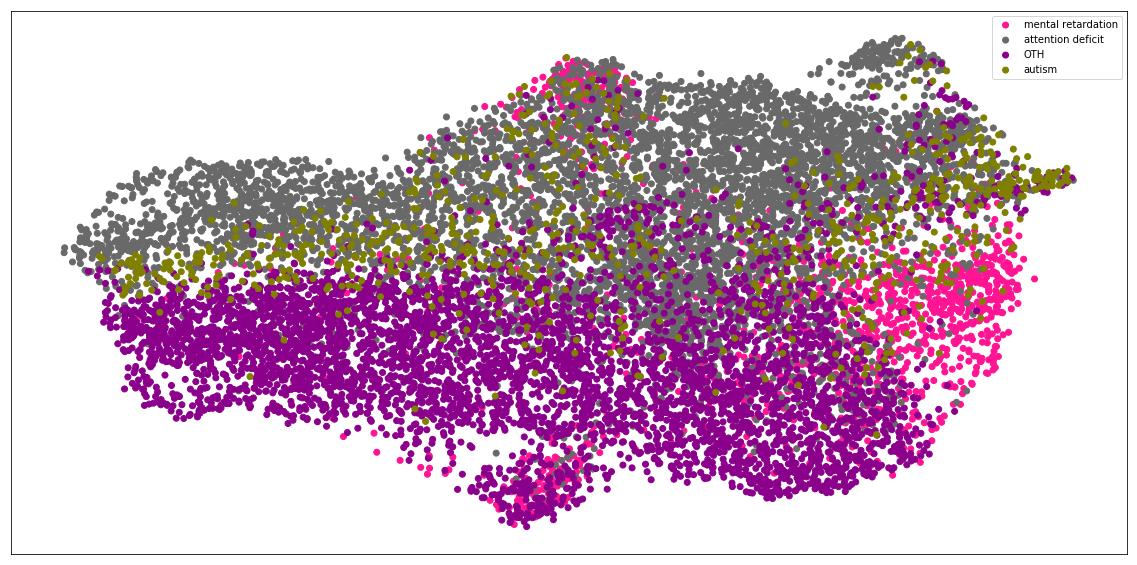

In [47]:
# plot data
colors_en1 = [colormap[disease_dict[v]] for v in disease_class_first]
single_plot(encoded_umap, disease_class_first, colors_en1)

In [48]:
# nonoverlap_plot(encoded_umap, disease_class_first, colors_en1)

Cluster: 0 -- Entropy: 1.632, Purity: 0.506
max(P) in cluster disease OTH
Cluster: 1 -- Entropy: 1.229, Purity: 0.722
max(P) in cluster disease attention deficit
Cluster: 2 -- Entropy: 1.594, Purity: 0.584
max(P) in cluster disease attention deficit
Cluster: 3 -- Entropy: 1.393, Purity: 0.517
max(P) in cluster disease OTH
Average Entropy: 1.47
Average Purity: 0.57
Cluster numerosity:4923
Cluster numerosity:3107
Cluster numerosity:1957
Cluster numerosity:3044


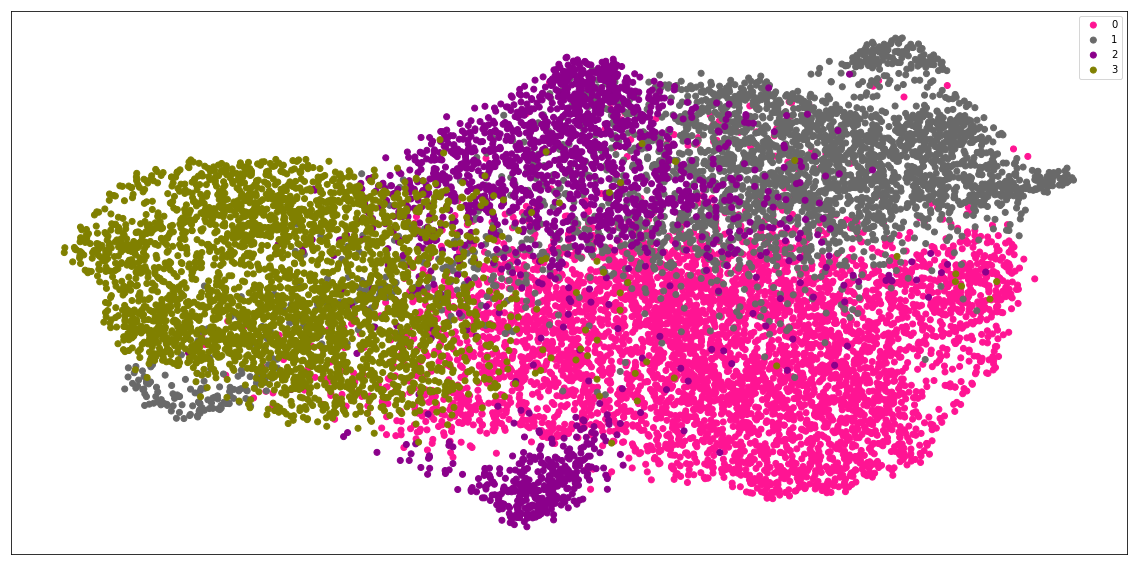

In [65]:
# plot cluster results
clusters = outer_clustering_analysis(encoded, disease_class_first, preproc=False)
colors_en2 = [colormap[v] for v in clusters]
single_plot(encoded_umap, clusters, colors_en2)
for i in range(len(set(clusters))):
    print("Cluster numerosity:{0}".format(clusters.count(i)))

 -- 2: 0.097
 -- 3: 0.072
 -- 4: 0.075
 -- 5: 0.064
 -- 6: 0.068
 -- 7: 0.071
 -- 8: 0.060
 -- 9: 0.064
 -- 10: 0.047
No. of clusters: 2 -- Silhouette Score: 0.097



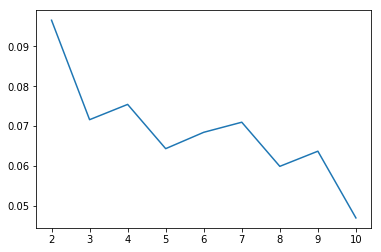

In [50]:
 _, _, _ = silhouette_analysis(encoded, preproc=False)

In [51]:
# inner clustering analysis
encoded_subplots, en_sub_clust = inner_clustering_analysis(disease_class_first, encoded, mrns, 
                                                           encoded_umap, preproc=False)

Inspecting disease: OTH

2 0.10577868631938932
3 0.10833470825638439
4 0.09016164604725373
5 0.08823771858194639
6 0.06294038422087037
7 0.06966787465785412
8 0.07234577090468708
9 0.056617050608153974
10 0.0564484827187463
Number of clusters found:3, Silhouette score:0.108

Cluster 0 numerosity: 1913
% most frequent term:icd9::Unspecified essential hypertension::401.9::C0085580 = 0.44 (4254 out of 9732 terms in the whole dataset-- N patients in cluster 895)
% most frequent term:medication::Fentanyl::4337::C0015846 = 0.35 (1292 out of 3689 terms in the whole dataset-- N patients in cluster 768)
% most frequent term:medication::Sodium chloride::9863::C0037494 = 0.26 (1754 out of 6708 terms in the whole dataset-- N patients in cluster 761)
% most frequent term:medication::Oxycodone::7804::C0030049 = 0.34 (1646 out of 4828 terms in the whole dataset-- N patients in cluster 751)
% most frequent term:medication::Ondansetron::26225::C0061851 = 0.32 (1290 out of 4018 terms in the whole datase

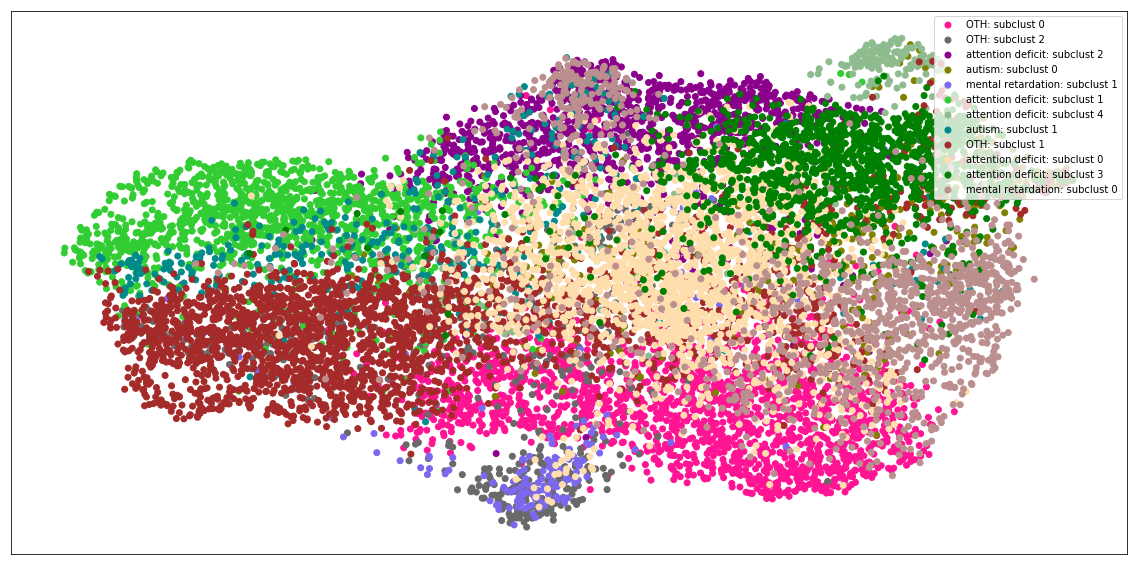

In [52]:
encoded_new_disease_dict = {}
for idx, nd in enumerate(set(en_sub_clust)):
    encoded_new_disease_dict[nd] = idx
colors_en3 = [colormap[encoded_new_disease_dict[v]] for v in en_sub_clust]
single_plot(encoded_subplots, en_sub_clust, colors_en3)

In [ ]:
# nonoverlap_plot(encoded_subplots, en_sub_clust, colors_en3)

### Raw Counts

In [ ]:
# plot data
# colors_raw1 = [colormap[disease_dict[v]] for v in disease_class_first]
# single_plot(raw_tsne, disease_class_first, colors_raw1)

# plot cluster results
# clusters = outer_clustering_analysis(raw_data_scaled, gt_disease.values())
# colors_raw2 = [colormap[v] for v in clusters]
# single_plot(raw_tsne, clusters, colors_raw2)

### Tfidf matrix

Cluster: 0 -- Entropy: 1.706, Purity: 0.410
max(P) in cluster disease mental retardation
Cluster: 1 -- Entropy: 1.587, Purity: 0.455
max(P) in cluster disease attention deficit
Cluster: 2 -- Entropy: 1.483, Purity: 0.513
max(P) in cluster disease autism
Cluster: 3 -- Entropy: 1.239, Purity: 0.739
max(P) in cluster disease attention deficit
Average Entropy: 1.58
Average Purity: 0.47
Cluster numerosity:944
Cluster numerosity:11311
Cluster numerosity:113
Cluster numerosity:663
 -- 2: 0.597
 -- 3: 0.595
 -- 4: 0.581
 -- 5: 0.576
 -- 6: 0.515
 -- 7: 0.515
 -- 8: 0.515
 -- 9: 0.518
 -- 10: 0.520
No. of clusters: 2 -- Silhouette Score: 0.597

Inspecting disease: OTH

2 0.9491890941061404
3 0.9479440236178482
4 0.9464790146648145
5 0.7052206893181767
6 0.5543837657286406
7 0.5544698381339661
8 0.5577297244763834
9 0.5587859180035019
10 0.5669905594005593
Number of clusters found:2, Silhouette score:0.949

Cluster 0 numerosity: 4
% most frequent term:medication::Glucagon::4832::C0017687 = 0.08 

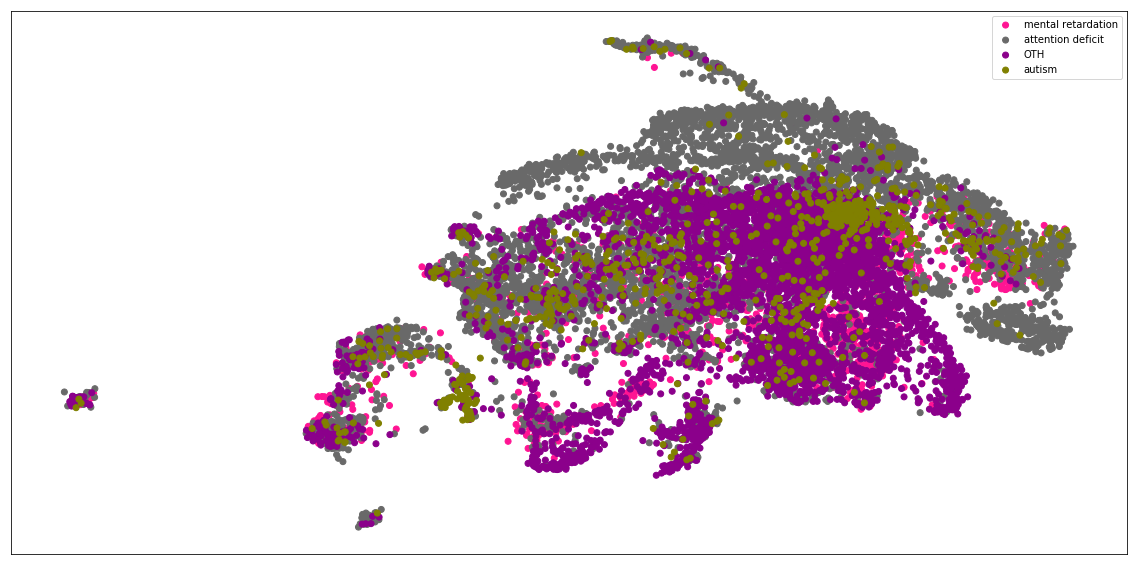

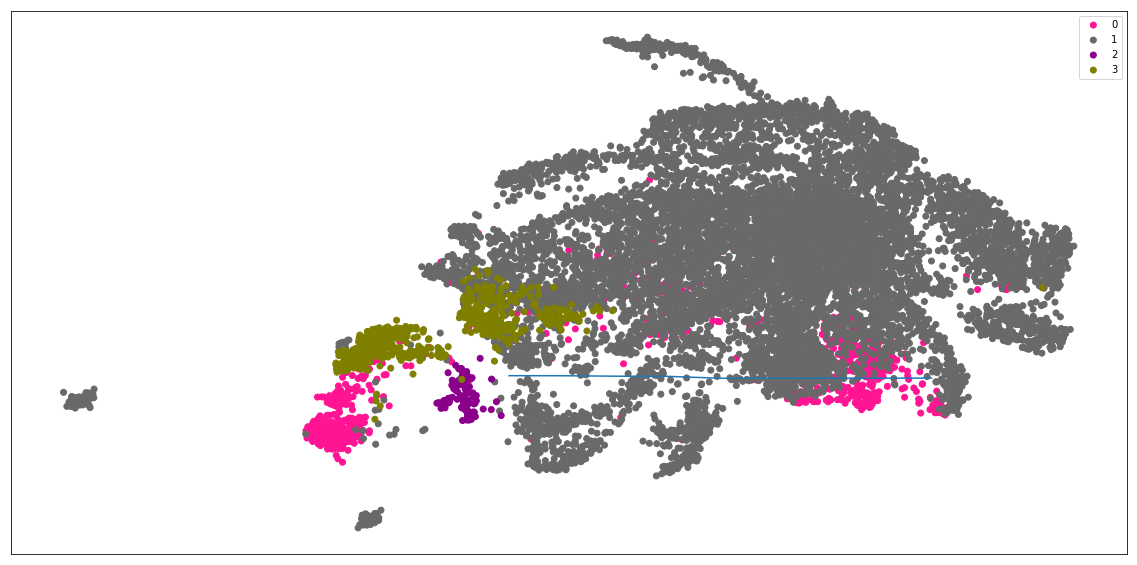

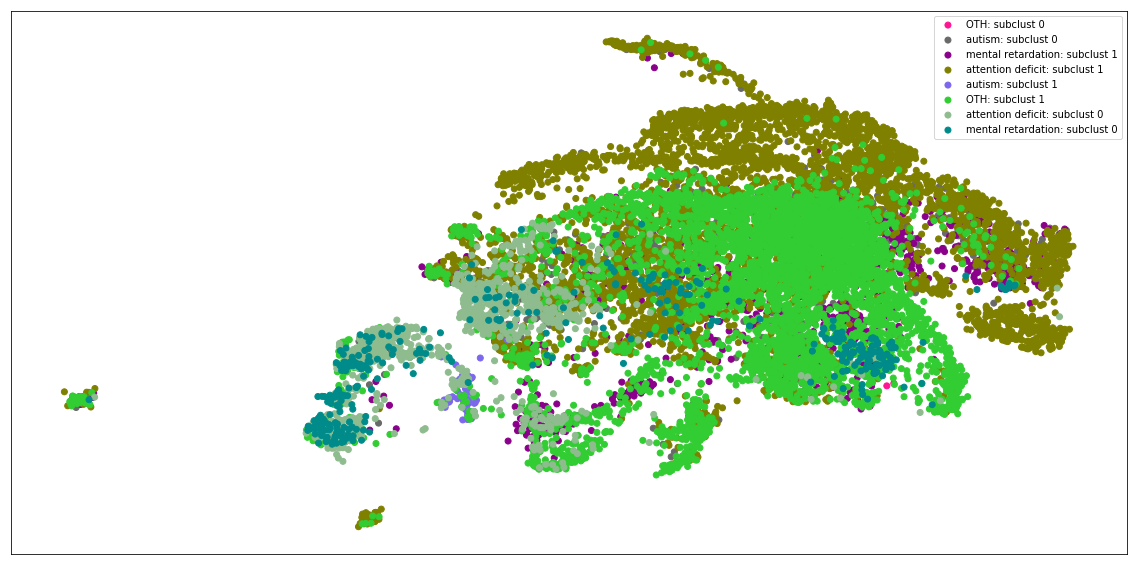

In [66]:
# plot data
colors_tfidf1 = [colormap[disease_dict[v]] for v in raw_disease_class_first]
single_plot(tfidf_umap, raw_disease_class_first, colors_tfidf1)

# nonoverlap_plot(tfidf_umap, disease_class_first, colors_en1)

# plot cluster results
clusters = outer_clustering_analysis(svd_mat, raw_disease_class_first)
colors_tfidf2 = [colormap[v] for v in clusters]
single_plot(tfidf_umap, clusters, colors_tfidf2)
for i in range(len(set(clusters))):
    print("Cluster numerosity:{0}".format(clusters.count(i)))
    
_,_,_ = silhouette_analysis(svd_mat)

tfidf_subplots, tfidf_sub_clust = inner_clustering_analysis(raw_disease_class_first, svd_mat, 
                                                            mrn_list, tfidf_umap)

tfidf_new_disease_dict = {}
for idx, nd in enumerate(set(tfidf_sub_clust)):
    tfidf_new_disease_dict[nd] = idx
colors_count3 = [colormap[tfidf_new_disease_dict[v]] for v in tfidf_sub_clust]
single_plot(tfidf_subplots, tfidf_sub_clust, colors_count3)

## LSTM encodings

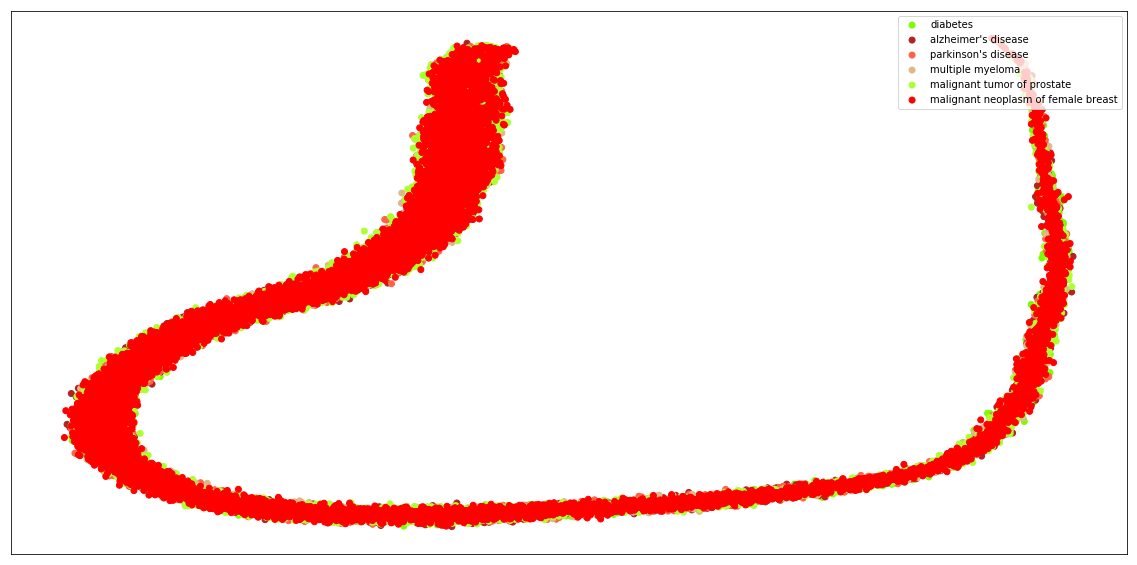

In [17]:
# plot data
colors_lstm1 = [colormap[disease_dict[v]] for v in lstm_disease_class_first]
single_plot(lstm_encoded_umap, lstm_disease_class_first, colors_lstm1)

Cluster: 0 -- Entropy: 2.327, Purity: 0.322
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 1 -- Entropy: 1.945, Purity: 0.393
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 1.783, Purity: 0.439
max(P) in cluster disease malignant tumor of prostate
Cluster: 3 -- Entropy: 2.013, Purity: 0.467
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 4 -- Entropy: 1.881, Purity: 0.538
max(P) in cluster disease malignant tumor of prostate
Cluster: 5 -- Entropy: 0.592, Purity: 0.857
max(P) in cluster disease malignant tumor of prostate
Average Entropy: 2.32
Average Purity: 0.32


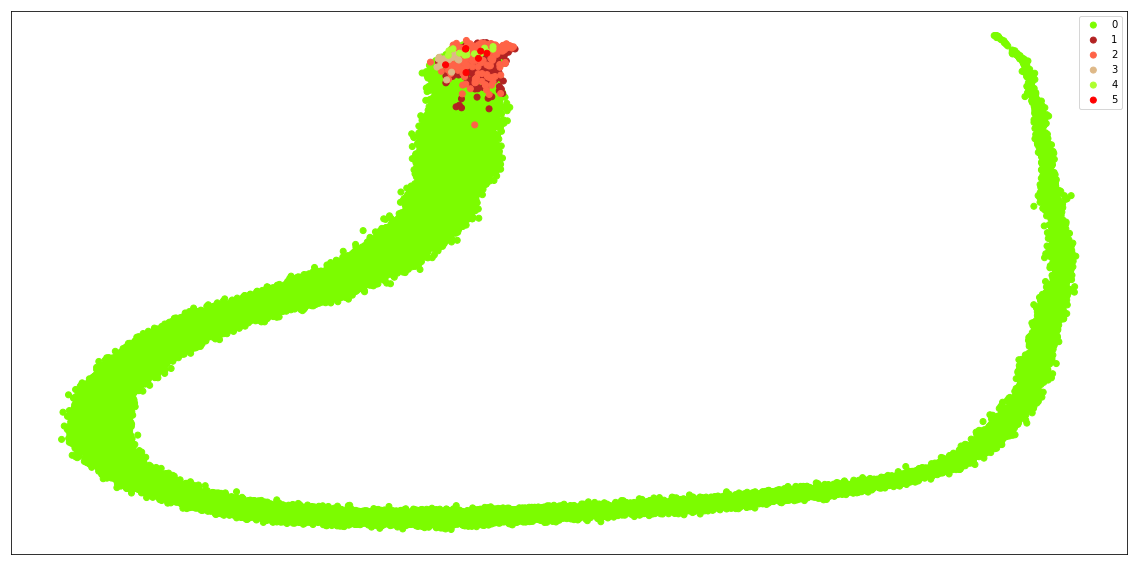

In [19]:
# plot cluster results
clusters = outer_clustering_analysis(lstm_encoded_vect, lstm_disease_class_first)
colors_lstm2 = [colormap[v] for v in clusters]
single_plot(lstm_encoded_umap, clusters, colors_lstm2)

Inspecting disease: alzheimer's disease

2 0.4139225350128534
3 0.33538510332903815
4 0.31919150230791027
5 0.3192827142872873
6 0.31113355595526754
7 0.24856781689135451
8 0.23899252772728571
9 0.22775707718334456
10 0.22740338540563423
Number of clusters found:2, Silhouette score:0.414

Cluster 0 numerosity: 3113
% most frequent term:icd9::Unspecified essential hypertension::401.9::C0085580 = 0.17 (24012 out of 142102 terms in the whole dataset-- N patients in cluster 2282)
% most frequent term:icd9::Alzheimer's disease::331.0::C0002395 = 0.94 (21571 out of 22887 terms in the whole dataset-- N patients in cluster 3113)
% most frequent term:icd9::Diabetes mellitus without mention of complication, type ii or unspecified type, not stated as uncontrolled::250.00::C0375113 = 0.11 (10886 out of 95229 terms in the whole dataset-- N patients in cluster 857)
% most frequent term:icd9::Pure hypercholesterolemia::272.0::C0678189 = 0.23 (10057 out of 43839 terms in the whole dataset-- N patients

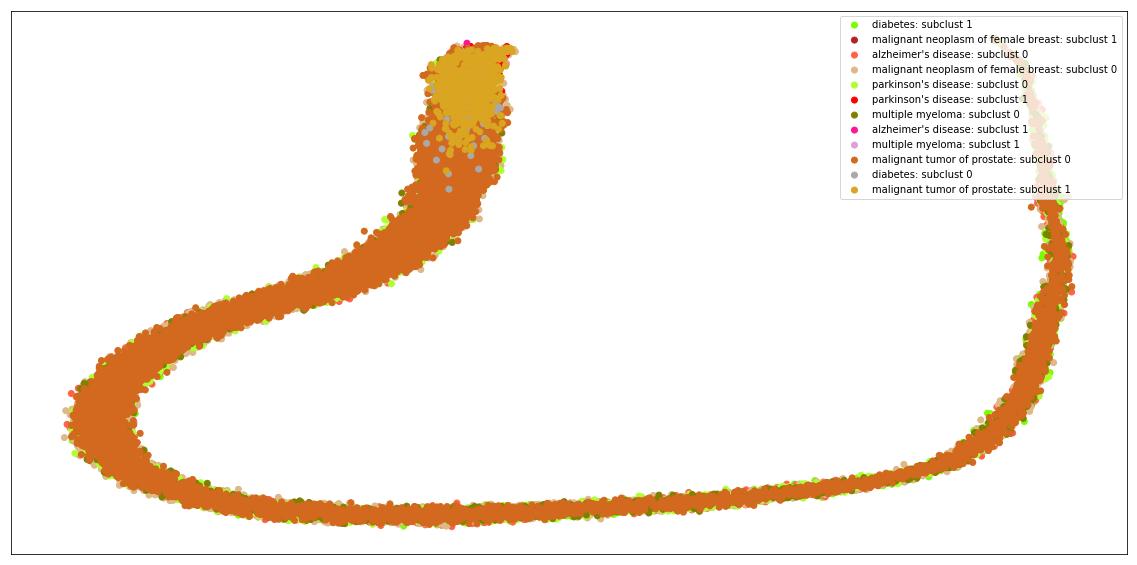

In [21]:
lstm_subplots, lstm_sub_clust = inner_clustering_analysis(lstm_disease_class_first, lstm_encoded_vect, 
                                                          lstm_mrns, lstm_encoded_umap)

lstm_new_disease_dict = {}
for idx, nd in enumerate(set(lstm_sub_clust)):
    lstm_new_disease_dict[nd] = idx
colors_lstm3 = [colormap[lstm_new_disease_dict[v]] for v in lstm_sub_clust]
single_plot(lstm_subplots, lstm_sub_clust, colors_lstm3)

## Results
```mixed-nobn-act-relu-10-overlap5-l32```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 2.346, Purity: 0.341
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 1 -- Entropy: 2.087, Purity: 0.382
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 1.662, Purity: 0.527
max(P) in cluster disease OTH
Cluster: 3 -- Entropy: 0.347, Purity: 0.953
max(P) in cluster disease multiple myeloma
Cluster: 4 -- Entropy: 1.719, Purity: 0.408
max(P) in cluster disease parkinson's disease
Cluster: 5 -- Entropy: 0.826, Purity: 0.839
max(P) in cluster disease malignant tumor of prostate
Average Entropy: 1.85
Average Purity: 0.48
```

__Inner analysis (scaled)__

```
OTH -- 2 -- 0.199
Alzheimer's -- 2 -- 0.254
Breast Cancer -- 2 -- 0.205
Prostate Cancer -- 3 -- 0.090
MM -- 2 -- 0.182
Parkinson -- 2 -- 0.262
```

```mixed-icdmed-nobn-noact-norelu-10-overlap5-l64```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 2.257, Purity: 0.323
max(P) in cluster disease alzheimer's disease
Cluster: 1 -- Entropy: 2.197, Purity: 0.407
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 0.280, Purity: 0.963
max(P) in cluster disease malignant tumor of prostate
Cluster: 3 -- Entropy: 1.935, Purity: 0.343
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 4 -- Entropy: 0.479, Purity: 0.929
max(P) in cluster disease OTH
Cluster: 5 -- Entropy: 1.460, Purity: 0.525
max(P) in cluster disease multiple myeloma
Average Entropy: 1.75
Average Purity: 0.50
```

__Inner analysis (scaled)__

```
OTH -- 3 -- 0.108
Alzheimer's -- 3 -- 0.126
Breast Cancer -- 2 -- 0.111
Prostate Cancer -- 5 -- 0.125
MM -- 2 -- 0.175
Parkinson -- 2 -- 0.119
```

```mixed-nobn-noact-norelu-10-overlap5-l32```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 2.388, Purity: 0.257
max(P) in cluster disease OTH
Cluster: 1 -- Entropy: 2.390, Purity: 0.317
max(P) in cluster disease OTH
Cluster: 2 -- Entropy: 1.628, Purity: 0.519
max(P) in cluster disease OTH
Cluster: 3 -- Entropy: 0.170, Purity: 0.979
max(P) in cluster disease malignant tumor of prostate
Cluster: 4 -- Entropy: 0.430, Purity: 0.938
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 5 -- Entropy: 0.191, Purity: 0.976
max(P) in cluster disease multiple myeloma
Average Entropy: 1.77
Average Purity: 0.48
```

__Inner analysis (scaled)__

```
OTH -- 2 -- 0.097
Alzheimer's -- 2 -- 0.153
Breast Cancer -- 4 -- 0.108
Prostate Cancer -- 3 -- 0.105
MM -- 2 -- 0.217
Parkinson -- 2 -- 0.211
```

```mixed-icdmed-2019-03-08-10-35-14-median-nobn-noact-norelu-10-l64```

__Outer analysis (scaled)__

```
Cluster: 0 -- Entropy: 1.655, Purity: 0.460
max(P) in cluster disease parkinson's disease
Cluster: 1 -- Entropy: 2.436, Purity: 0.260
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 2 -- Entropy: 0.727, Purity: 0.859
max(P) in cluster disease OTH
Cluster: 3 -- Entropy: 1.753, Purity: 0.394
max(P) in cluster disease malignant tumor of prostate
Cluster: 4 -- Entropy: 0.267, Purity: 0.967
max(P) in cluster disease malignant neoplasm of female breast
Cluster: 5 -- Entropy: 1.446, Purity: 0.638
max(P) in cluster disease malignant tumor of prostate
Average Entropy: 1.77
Average Purity: 0.47
```

__Inner analysis (scaled)__

```
OTH -- 2 -- 0.121
Alzheimer's -- 2 -- 0.105 
Breast Cancer -- 3 -- 0.095
Prostate Cancer -- 3 -- 0.116
MM -- 5 -- 0.139
Parkinson -- 2 -- 0.147 
```